In [1]:
from pylab import *
from scipy import signal
import scipy
from scipy import *
from skimage import color
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from PIL import Image
import cv2
import skimage
from skimage.transform import SimilarityTransform
from skimage.transform import warp

In [2]:
left_img = cv2.imread("left.jpg")
right_img = cv2.imread("right.jpg")

left_double = color.rgb2gray(left_img).astype(np.double)
right_double = color.rgb2gray(right_img).astype(np.double)

left_gray= cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
right_gray= cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

left_sift = cv2.xfeatures2d.SIFT_create()
left_kp, left_des = left_sift.detectAndCompute(left_gray, None)
right_sift = cv2.xfeatures2d.SIFT_create()
right_kp, right_des = right_sift.detectAndCompute(right_gray, None)

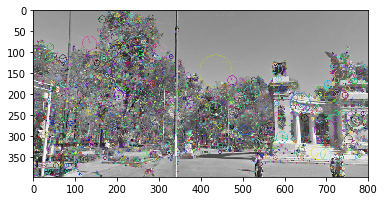

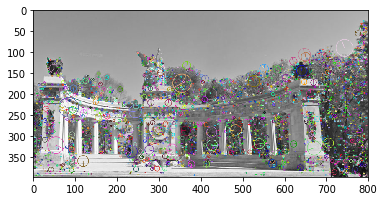

In [3]:
draw_left_kp = cv2.drawKeypoints(left_gray, left_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(draw_left_kp)
plt.show()
draw_right_kp = cv2.drawKeypoints(right_gray, right_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(draw_right_kp)
plt.show()

In [4]:
# 4. Compute distances between every descriptor in one image and every descriptor in the other image
des_distance = scipy.spatial.distance.cdist(left_des, right_des, 'sqeuclidean')

In [5]:
# 5.Select putative matches based on the matrix of pairwise descriptor distances obtained above
pair_num = 200
# find pair_num small items
small = np.sort(des_distance, axis = None)[:pair_num]
left_idx = []
right_idx = []
for i in range(len(left_kp)):
    for j in range(len(right_kp)):
        if des_distance[i, j] in small:
            left_idx.append(i)
            right_idx.append(j)

In [6]:
# Implement RANSAC to estimate a homography mapping one image onto the other.
loop_num = 4000
inlier_threshold = 5
H_result = []
inlier_result = []
total_residual_result = []
inlier_list = []
for counter in range(loop_num):
    # randomly select 4 matches
    random_idx = np.arange(pair_num)
    np.random.shuffle(random_idx)
    idx_list = random_idx[:4]
    
    left_coord_x = []
    left_coord_y = []
    
    right_coord_x = []
    right_coord_y = []
    for i in range(4):
        left_coord_x.append(left_kp[left_idx[idx_list[i]]].pt[0])
        left_coord_y.append(left_kp[left_idx[idx_list[i]]].pt[1])
        
        right_coord_x.append(right_kp[right_idx[idx_list[i]]].pt[0])
        right_coord_y.append(right_kp[right_idx[idx_list[i]]].pt[1])
    
    # Set up A
    A = np.zeros((8, 9))
    A[0, 0] = 0
    A[0, 1] = 0
    A[0, 2] = 0
    A[0, 3] = left_coord_x[0]
    A[0, 4] = left_coord_y[0]
    A[0, 5] = 1
    A[0, 6] = -1 * right_coord_y[0] * left_coord_x[0]
    A[0, 7] = -1 * right_coord_y[0] * left_coord_y[0]
    A[0, 8] = -1 * right_coord_y[0] * 1
    
    A[1, 0] = left_coord_x[0]
    A[1, 1] = left_coord_y[0]
    A[1, 2] = 1
    A[1, 3] = 0
    A[1, 4] = 0
    A[1, 5] = 0
    A[1, 6] = -1 * right_coord_x[0] * left_coord_x[0]
    A[1, 7] = -1 * right_coord_x[0] * left_coord_y[0]
    A[1, 8] = -1 * right_coord_x[0] * 1
    
    A[2, 0] = 0
    A[2, 1] = 0
    A[2, 2] = 0
    A[2, 3] = left_coord_x[1]
    A[2, 4] = left_coord_y[1]
    A[2, 5] = 1
    A[2, 6] = -1 * right_coord_y[1] * left_coord_x[1]
    A[2, 7] = -1 * right_coord_y[1] * left_coord_y[1]
    A[2, 8] = -1 * right_coord_y[1] * 1
    
    A[3, 0] = left_coord_x[1]
    A[3, 1] = left_coord_y[1]
    A[3, 2] = 1
    A[3, 3] = 0
    A[3, 4] = 0
    A[3, 5] = 0
    A[3, 6] = -1 * right_coord_x[1] * left_coord_x[1]
    A[3, 7] = -1 * right_coord_x[1] * left_coord_y[1]
    A[3, 8] = -1 * right_coord_x[1] * 1
    
    A[4, 0] = 0
    A[4, 1] = 0
    A[4, 2] = 0
    A[4, 3] = left_coord_x[2]
    A[4, 4] = left_coord_y[2]
    A[4, 5] = 1
    A[4, 6] = -1 * right_coord_y[2] * left_coord_x[2]
    A[4, 7] = -1 * right_coord_y[2] * left_coord_y[2]
    A[4, 8] = -1 * right_coord_y[2] * 1
    
    A[5, 0] = left_coord_x[2]
    A[5, 1] = left_coord_y[2]
    A[5, 2] = 1
    A[5, 3] = 0
    A[5, 4] = 0
    A[5, 5] = 0
    A[5, 6] = -1 * right_coord_x[2] * left_coord_x[2]
    A[5, 7] = -1 * right_coord_x[2] * left_coord_y[2]
    A[5, 8] = -1 * right_coord_x[2] * 1
    
    A[6, 0] = 0
    A[6, 1] = 0
    A[6, 2] = 0
    A[6, 3] = left_coord_x[3]
    A[6, 4] = left_coord_y[3]
    A[6, 5] = 1
    A[6, 6] = -1 * right_coord_y[3] * left_coord_x[3]
    A[6, 7] = -1 * right_coord_y[3] * left_coord_y[3]
    A[6, 8] = -1 * right_coord_y[3] * 1
    
    A[7, 0] = left_coord_x[3]
    A[7, 1] = left_coord_y[3]
    A[7, 2] = 1
    A[7, 3] = 0
    A[7, 4] = 0
    A[7, 5] = 0
    A[7, 6] = -1 * right_coord_x[3] * left_coord_x[3]
    A[7, 7] = -1 * right_coord_x[3] * left_coord_y[3]
    A[7, 8] = -1 * right_coord_x[3] * 1
    
    
    # Solve for H
    U, s, V = np.linalg.svd(A)
    H  = V[len(V)-1]
    H = H.reshape((3,3))
    
    inlier_this_round = 0
    inlier_list_this_round = []
    total_residual = 0
    
    # find inliers
    for each_idx in random_idx[4: ]:
        left_original_coord_x = left_kp[left_idx[each_idx]].pt[0]
        left_original_coord_y = left_kp[left_idx[each_idx]].pt[1]
        
        right_original_coord_x = right_kp[right_idx[each_idx]].pt[0]
        right_original_coord_y = right_kp[right_idx[each_idx]].pt[1]
        
        res = np.matmul(H, np.array([left_original_coord_x, left_original_coord_y, 1]))
        
        right_new_coord_x = res[0] / res[2]
        right_new_coord_y = res[1] / res[2]
        
        residual = (right_new_coord_x - right_original_coord_x) ** 2 + (right_new_coord_y - right_original_coord_y) ** 2
        
        if residual <= inlier_threshold:
            inlier_this_round += 1
            total_residual += residual
            inlier_list_this_round.append(each_idx)
            
    H_result.append(H)
    inlier_result.append(inlier_this_round)
    total_residual_result.append(total_residual)
    inlier_list.append(inlier_list_this_round)
print("The number of inlier is: ", inlier_result[np.argmax(inlier_result)])
print("The average residual is: ", total_residual_result[np.argmax(inlier_result)] / inlier_result[np.argmax(inlier_result)])
optimal_H = H_result[np.argmax(inlier_result)]
optimal_inliers = inlier_list[np.argmax(inlier_result)]
print(optimal_inliers)

C:\Users\l4254\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\l4254\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in double_scalars


The number of inlier is:  68
The average residual is:  0.9371410089170666
[142, 134, 135, 120, 183, 130, 144, 182, 179, 152, 165, 88, 89, 172, 154, 128, 127, 184, 146, 189, 196, 129, 155, 137, 113, 105, 187, 125, 68, 180, 111, 140, 145, 161, 198, 171, 159, 126, 195, 124, 151, 115, 175, 167, 117, 136, 153, 121, 148, 199, 138, 177, 170, 79, 190, 169, 107, 163, 186, 149, 166, 67, 176, 160, 119, 143, 156, 181]


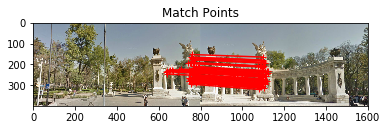

In [7]:
##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I1 = Image.open('left.jpg')
I2 = Image.open('right.jpg')

part1_match = []
for each_idx in optimal_inliers:
    part1_match.append([left_kp[left_idx[each_idx]].pt[0], left_kp[left_idx[each_idx]].pt[1], right_kp[right_idx[each_idx]].pt[0], right_kp[right_idx[each_idx]].pt[1]])
    
part1_match = np.asarray(part1_match)    
    
I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('Match Points')
ax.imshow(np.array(I3/255.).astype(float))
ax.plot(part1_match[:,0], part1_match[:,1],  '+r')
ax.plot( part1_match[:,2]+I1.size[0],part1_match[:,3], '+r')
ax.plot([part1_match[:,0], part1_match[:,2]+I1.size[0]],[part1_match[:,1], part1_match[:,3]], 'r')
plt.savefig('Part1_match_inliers')
plt.show()

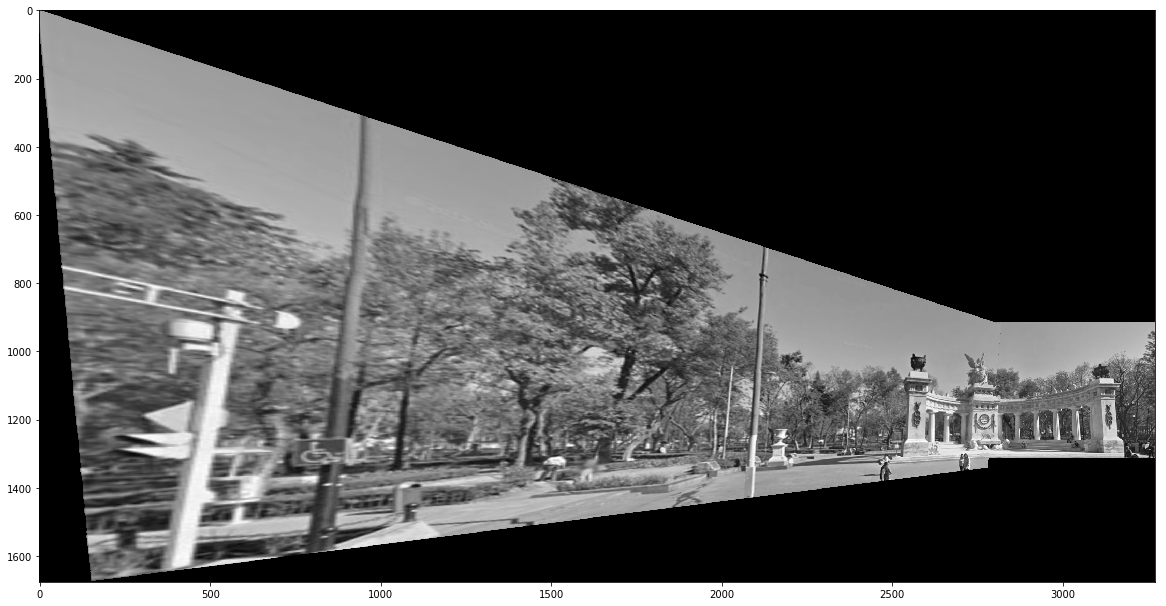

In [8]:
def warp_images(image0, image1, transform):
    r, c = image1.shape[:2]
    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners = transform(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = SimilarityTransform(translation=-corner_min)

    image0_ = warp(image0, offset.inverse, output_shape=output_shape, cval=-1)

    image1_ = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=-1)

    image0_zeros = warp(image0, offset.inverse, output_shape=output_shape, cval=0)

    image1_zeros = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=0)

    merged = image0_zeros * ((image1_ < 0.02).astype(int)) + image1_zeros * ((image1_ >= 0.02).astype(int))
    plt.figure(figsize = (20, 20))
    plt.imshow(merged, cmap = 'gray')

transform_arg = skimage.transform.ProjectiveTransform(optimal_H)
warp_images(right_double, left_double, transform_arg)

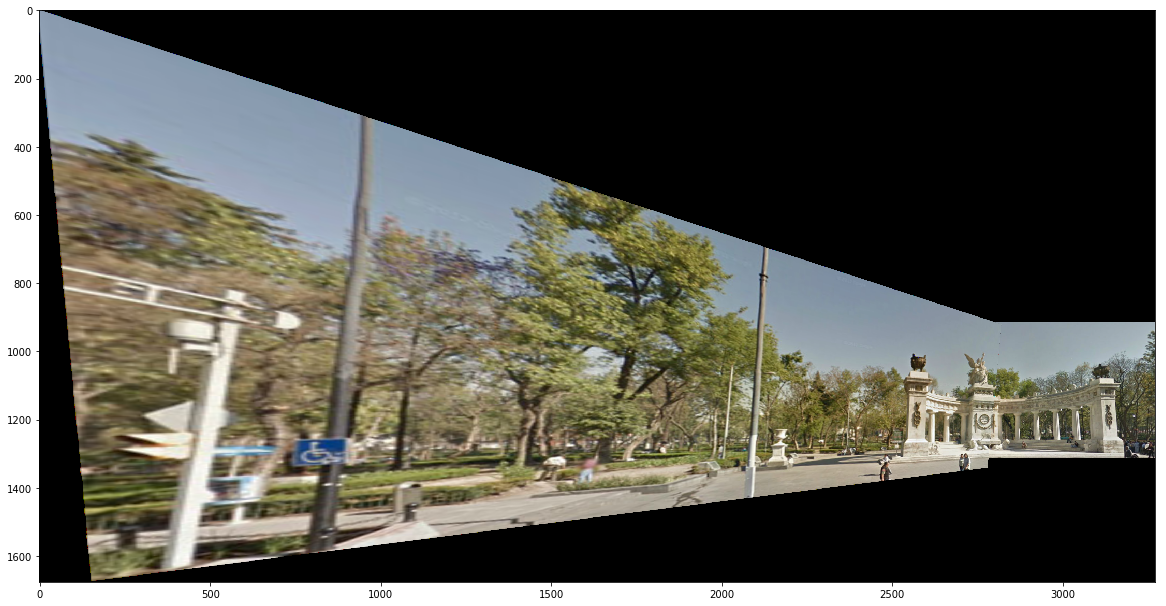

In [9]:
def warp_images_color(image0, image1, transform):
    r, c = image1.shape[:2]
    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners = transform(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = SimilarityTransform(translation=-corner_min)

    image0_ = warp(image0, offset.inverse, output_shape=output_shape, cval=-1)

    image1_ = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=-1)

    image0_zeros = warp(image0, offset.inverse, output_shape=output_shape, cval=0)

    image1_zeros = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=0)

    merged = image0_zeros * ((image1_ < 0.02).astype(int)) + image1_zeros * ((image1_ >= 0.02).astype(int))
    plt.figure(figsize = (20, 20))
    plt.imshow(merged)
    
left_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_rgb = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

warp_images_color(right_rgb, left_rgb, transform_arg)

# Part 2

## 1. Fundamental matrix estimation.

### Library

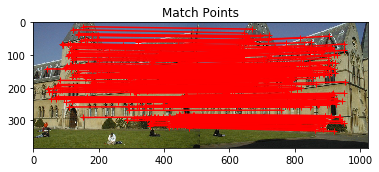

In [10]:
# 1. Fundamental matrix estimation.

##
## load images and match files for the first example
##
I1 = Image.open('library1.jpg')
I2 = Image.open('library2.jpg')
matches = np.loadtxt('library_matches.txt')

N = len(matches)
##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('Match Points')
ax.imshow(np.array(I3/255.).astype(float))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()

Residual for Normalized Algorithm for Library is:  0.18359661716193246


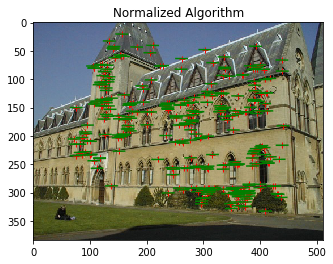

In [11]:
# Normalized

# Reference for calculating normalized fundamental matrix
# https://cs.adelaide.edu.au/~wojtek/papers/pami-nals2.pdf, page 2
def fit_fundamental_normalized(matches):
    N = len(matches)
    mean_of_column = np.mean(matches, axis = 0)
    matches_zero_mean = matches - mean_of_column
    
    total1 = 0
    for i in range(N):
        for j in range(2):
            total1 += matches_zero_mean[i, j] ** 2
    
    total2 = 0
    for i in range(N):
        for j in range(2):
            total2 += matches_zero_mean[i, j + 2] ** 2
            
    s1 = np.sqrt(total1 / (2 * N))
    s2 = np.sqrt(total2 / (2 * N))
    
    new_matches = matches_zero_mean
    
    for i in range(N):
        for j in range(2):
            new_matches[i, j] = new_matches[i, j] / s1
    for i in range(N):
        for j in range(2):
            new_matches[i, j + 2] = new_matches[i, j + 2] / s2
    
    T1 = np.zeros((3, 3))
    T1[0, 0] = 1 / s1
    T1[0, 2] = -1 * (1 / s1) * mean_of_column[0]
    T1[1, 1] = 1 / s1
    T1[1, 2] = -1 * (1 / s1) * mean_of_column[1]
    T1[2, 2] = 1
    
    T2 = np.zeros((3, 3))
    T2[0, 0] = 1 / s2
    T2[0, 2] = -1 * (1 / s2) * mean_of_column[2]
    T2[1, 1] = 1 / s2
    T2[1, 2] = -1 * (1 / s2) * mean_of_column[3]
    T2[2, 2] = 1
    
    M_points = np.zeros((N, 9)) 
    for i in range(N):
        u1, v1 = new_matches[i, 0 : 2]
        u2, v2 = new_matches[i, 2 : 4]
        M_points[i, 0] = u1 * u2
        M_points[i, 1] = v1 * u2
        M_points[i, 2] = u2
        M_points[i, 3] = u1 * v2
        M_points[i, 4] = v1 * v2
        M_points[i, 5] = v2
        M_points[i, 6] = u1
        M_points[i, 7] = v1
        M_points[i, 8] = 1
        
    U, s, V = np.linalg.svd(M_points)
    F = V[len(V)-1]
    F = F.reshape(3,3)
    
    # enforce rank 2
    U, s, V = np.linalg.svd(F)
    s[-1] = 0
    new_s = s * np.identity(3)
    new_F = np.matmul(np.matmul(U, new_s), V)
    
    new_F = np.matmul(np.matmul(T2.T, new_F), T1)
    return new_F
##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
F = fit_fundamental_normalized(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

residual = np.mean(np.abs(pt_line_dist))
print('Residual for Normalized Algorithm for Library is: ', residual)

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_title('Normalized Algorithm')
ax.set_aspect('equal')
ax.imshow(np.array(I2))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

Residual for Unnormalized Algorithm for Library is:  0.33849509606031347


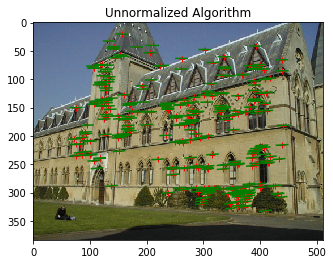

In [12]:
def fit_fundamental_unnormalized(matches):
    N = len(matches)
    M_points = np.zeros((N, 9)) 
    for i in range(N):
        u1, v1 = matches[i, 0 : 2]
        u2, v2 = matches[i, 2 : 4]
        M_points[i, 0] = u1 * u2
        M_points[i, 1] = v1 * u2
        M_points[i, 2] = u2
        M_points[i, 3] = u1 * v2
        M_points[i, 4] = v1 * v2
        M_points[i, 5] = v2
        M_points[i, 6] = u1
        M_points[i, 7] = v1
        M_points[i, 8] = 1
        
    U, s, V = np.linalg.svd(M_points)
    F = V[len(V)-1]
    F = F.reshape(3,3)
    
    # enforce rank 2
    U, s, V = np.linalg.svd(F)
    s[-1] = 0
    new_s = np.zeros((3, 3))
    new_s[0, 0] = s[0]
    new_s[1, 1] = s[1]
    new_F = np.matmul(np.matmul(U, new_s), V)
    
    return new_F

##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
F = fit_fundamental_unnormalized(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

residual = np.mean(np.abs(pt_line_dist))
print('Residual for Unnormalized Algorithm for Library is: ', residual)

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_title('Unnormalized Algorithm')
ax.set_aspect('equal')
ax.imshow(np.array(I2))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

### Lab

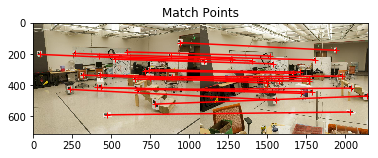

In [13]:
# 1. Fundamental matrix estimation.

##
## load images and match files for the first example
##
I1 = Image.open('lab1.jpg')
I2 = Image.open('lab2.jpg')
matches = np.loadtxt('lab_matches.txt')

N = len(matches)
##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('Match Points')
ax.imshow(np.array(I3/255.).astype(float))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()

Residual for Normalized Algorithm for Lab is:  0.6172517559032386


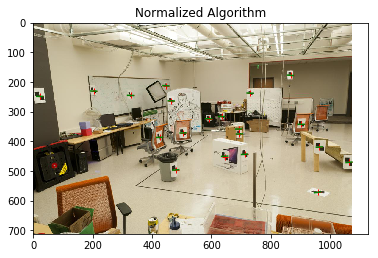

In [14]:
# Normalized

# Reference for calculating normalized fundamental matrix
# https://cs.adelaide.edu.au/~wojtek/papers/pami-nals2.pdf, page 2
def fit_fundamental_normalized(matches):
    N = len(matches)
    mean_of_column = np.mean(matches, axis = 0)
    matches_zero_mean = matches - mean_of_column
    
    total1 = 0
    for i in range(N):
        for j in range(2):
            total1 += matches_zero_mean[i, j] ** 2
    
    total2 = 0
    for i in range(N):
        for j in range(2):
            total2 += matches_zero_mean[i, j + 2] ** 2
            
    s1 = np.sqrt(total1 / (2 * N))
    s2 = np.sqrt(total2 / (2 * N))
    
    new_matches = matches_zero_mean
    
    for i in range(N):
        for j in range(2):
            new_matches[i, j] = new_matches[i, j] / s1
    for i in range(N):
        for j in range(2):
            new_matches[i, j + 2] = new_matches[i, j + 2] / s2
            
    
    T1 = np.zeros((3, 3))
    T1[0, 0] = 1 / s1
    T1[0, 2] = -1 * (1 / s1) * mean_of_column[0]
    T1[1, 1] = 1 / s1
    T1[1, 2] = -1 * (1 / s1) * mean_of_column[1]
    T1[2, 2] = 1
    
    T2 = np.zeros((3, 3))
    T2[0, 0] = 1 / s2
    T2[0, 2] = -1 * (1 / s2) * mean_of_column[2]
    T2[1, 1] = 1 / s2
    T2[1, 2] = -1 * (1 / s2) * mean_of_column[3]
    T2[2, 2] = 1
    
    M_points = np.zeros((N, 9)) 
    for i in range(N):
        u1, v1 = new_matches[i, 0 : 2]
        u2, v2 = new_matches[i, 2 : 4]
        M_points[i, 0] = u1 * u2
        M_points[i, 1] = v1 * u2
        M_points[i, 2] = u2
        M_points[i, 3] = u1 * v2
        M_points[i, 4] = v1 * v2
        M_points[i, 5] = v2
        M_points[i, 6] = u1
        M_points[i, 7] = v1
        M_points[i, 8] = 1
        
    U, s, V = np.linalg.svd(M_points)
    F = V[len(V)-1]
    F = F.reshape(3,3)
    
    # enforce rank 2
    U, s, V = np.linalg.svd(F)
    s[-1] = 0
    new_s = s * np.identity(3)
    new_F = np.matmul(np.matmul(U, new_s), V)
    
    new_F = np.matmul(np.matmul(T2.T, new_F), T1)
    return new_F

##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
F = fit_fundamental_normalized(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

residual = np.mean(np.abs(pt_line_dist))
print('Residual for Normalized Algorithm for Lab is: ', residual)

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_title('Normalized Algorithm')
ax.set_aspect('equal')
ax.imshow(np.array(I2))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

Residual for Unnormalized Algorithm for Lab is:  2.237977425349455


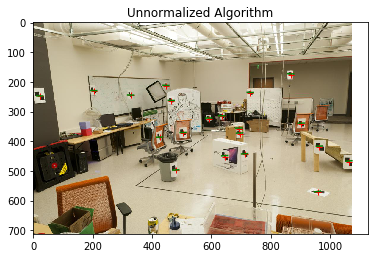

In [15]:
def fit_fundamental_unnormalized(matches):
    N = len(matches)
    M_points = np.zeros((N, 9)) 
    for i in range(N):
        u1, v1 = matches[i, 0 : 2]
        u2, v2 = matches[i, 2 : 4]
        M_points[i, 0] = u1 * u2
        M_points[i, 1] = v1 * u2
        M_points[i, 2] = u2
        M_points[i, 3] = u1 * v2
        M_points[i, 4] = v1 * v2
        M_points[i, 5] = v2
        M_points[i, 6] = u1
        M_points[i, 7] = v1
        M_points[i, 8] = 1
        
    U, s, V = np.linalg.svd(M_points)
    F = V[len(V)-1]
    F = F.reshape(3,3)
    
    # enforce rank 2
    U, s, V = np.linalg.svd(F)
    s[-1] = 0
    new_s = np.zeros((3, 3))
    new_s[0, 0] = s[0]
    new_s[1, 1] = s[1]
    new_F = np.matmul(np.matmul(U, new_s), V)
    
    return new_F


##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
F = fit_fundamental_unnormalized(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

residual = np.mean(np.abs(pt_line_dist))
print('Residual for Unnormalized Algorithm for Lab is: ', residual)

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_title('Unnormalized Algorithm')
ax.set_aspect('equal')
ax.imshow(np.array(I2))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

## 2. Camera Calibration

In [16]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [17]:
matches = np.loadtxt('lab_matches.txt')
lab_3d = np.loadtxt('lab_3d.txt')
lab1_matches = matches[:, : 2]
lab2_matches = matches[:, 2 :]

def find_projection_matrix(threeD_points, twoD_points):
    N = len(threeD_points)
    A = np.zeros((N, 12))
    
    for i in range(int(N / 2)):
        X = np.array([threeD_points[i, 0], threeD_points[i, 1], threeD_points[i, 2], 1])

        A[2 * i, 4 : 8] = X
        A[2 * i, 8 : 12] = -1 * twoD_points[i, 1] * X
        
        A[2 * i + 1, 0 : 4] = X
        A[2 * i + 1, 8 : 12] = -1 * twoD_points[i, 0] * X
        
    U, s, V = np.linalg.svd(A)
    P  = V[len(V)-1]
    P = P.reshape((3, 4))

    return P

lab1_camera_matrix = find_projection_matrix(lab_3d, lab1_matches)
lab2_camera_matrix = find_projection_matrix(lab_3d, lab2_matches)
print('Estimated camera projection matrix for lab1 is: \n', lab1_camera_matrix, '\n')
print('Estimated camera projection matrix for lab2 is: \n', lab2_camera_matrix, '\n')

proj1, lab1_camera_residual = evaluate_points(lab1_camera_matrix, lab1_matches, lab_3d)
proj2, lab2_camera_residual = evaluate_points(lab2_camera_matrix, lab2_matches, lab_3d)
print('The residual between the projected and observed 2D points for lab1 is: ', lab1_camera_residual)
print('The residual between the projected and observed 2D points for lab2 is: ', lab2_camera_residual)

Estimated camera projection matrix for lab1 is: 
 [[ 3.09971524e-03  1.46250174e-04 -4.48354919e-04 -9.78974905e-01]
 [ 3.06744636e-04  6.36810842e-04 -2.77389022e-03 -2.03932211e-01]
 [ 1.67995219e-06  2.74565792e-06 -6.83395792e-07 -1.32842138e-03]] 

Estimated camera projection matrix for lab2 is: 
 [[-6.88970692e-03  3.96429852e-03  1.39263702e-03  8.28289829e-01]
 [-1.53909600e-03 -1.02084411e-03  7.22962251e-03  5.60181867e-01]
 [-7.58603647e-06 -3.72293087e-06  2.03836990e-06  3.38133189e-03]] 

The residual between the projected and observed 2D points for lab1 is:  13.765505109334178
The residual between the projected and observed 2D points for lab2 is:  17.781125905791964


## 3. Calculate the camera centers

In [18]:
library1_camera_matrix = np.loadtxt('library1_camera.txt')
library2_camera_matrix = np.loadtxt('library2_camera.txt')

def find_camera_center(camera_center_matrix):
    U, s, V = np.linalg.svd(camera_center_matrix)
    center = V[len(V)-1]
    center = center / center[-1]
    return center

lab1_center = find_camera_center(lab1_camera_matrix)
lab2_center = find_camera_center(lab2_camera_matrix)
library1_center = find_camera_center(library1_camera_matrix)
library2_center = find_camera_center(library2_camera_matrix)
print(lab1_center)
print(lab2_center)
print(library1_center)
print(library2_center)

[305.83387882 304.20073002  30.13782356   1.        ]
[303.14001018 307.21161306  30.4296492    1.        ]
[  7.28863053 -21.52118112  17.73503585   1.        ]
[  6.89405488 -15.39232716  23.41498687   1.        ]


## 4. Triangulation

### Lab

[[312.78291956 309.14793677  30.08825937   1.        ]
 [305.79583985 311.647791    30.35938704   1.        ]
 [307.7005947  312.37217915  30.41674895   1.        ]
 [310.13440522 307.17943144  29.30057835   1.        ]
 [311.95788273 310.12008416  29.21275648   1.        ]
 [311.20691609 307.57555977  30.67950481   1.        ]
 [307.10774467 306.88091469  28.65793142   1.        ]
 [309.28133295 312.4486935   30.23054336   1.        ]
 [307.43935436 310.15100191  29.31303864   1.        ]
 [308.24268375 306.29876816  28.88661985   1.        ]
 [306.64235566 309.2992755   28.90589268   1.        ]
 [308.0651248  306.84106044  29.19401194   1.        ]
 [309.64168792 308.81128988  29.03262552   1.        ]
 [308.27460678 309.9739103   29.25778192   1.        ]
 [307.58012218 308.62549965  28.95332987   1.        ]
 [311.08075193 309.20605436  28.88932969   1.        ]
 [307.52743213 308.18738654  29.06369628   1.        ]
 [309.93933906 311.25779992  29.99069135   1.        ]
 [312.2454

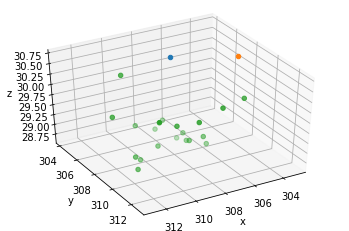

In [19]:
lab_matches = np.loadtxt('lab_matches.txt')
N = len(lab_matches)

# 2d points on two images
attach = np.ones((N, 1))
x1 = np.hstack((lab_matches[:, : 2], attach))
x2 = np.hstack((lab_matches[:, 2 :], attach))

X_3d = np.zeros((N, 4))
for i in range(N):
    x_1 = np.zeros((3, 3))
    x_1[0, 1] = -1 * x1[i, 2]
    x_1[0, 2] = x1[i, 1]
    x_1[1, 0] = x1[i, 2]
    x_1[1, 2] = -1 * x1[i, 0]
    x_1[2, 0] = -1 * x1[i, 1]
    x_1[2, 1] = x1[i, 0]
    
    x_2 = np.zeros((3, 3))
    x_2[0, 1] = -1 * x2[i, 2]
    x_2[0, 2] = x2[i, 1]
    x_2[1, 0] = x2[i, 2]
    x_2[1, 2] = -1 * x2[i, 0]
    x_2[2, 0] = -1 * x2[i, 1]
    x_2[2, 1] = x2[i, 0]

    A_x1 = np.matmul(x_1, lab1_camera_matrix)
    A_x2 = np.matmul(x_2, lab2_camera_matrix)
    A = np.vstack((A_x1, A_x2))

    U, s, V = np.linalg.svd(A)
    sol = V[len(V)-1]
    X_3d[i] = sol / sol[-1]

# X_3d = X_3d[:, :-1]
print(X_3d)

# Residual
residual_1 = 0
for i in range(N):
    # project to 2d
    x_1 = np.matmul(lab1_camera_matrix, X_3d[i])
    x_1 = x_1 / x_1[-1]
    x_1 = x_1[: -1]
    residual_1 += np.sum(np.square(x_1 - lab_matches[i, : 2]))
residual_1 = residual_1 / (2 * N)
print('Residuals between the observed 2D points and the projected 3D points for lab1', residual_1)
residual_2 = 0
for i in range(N):
    x_2 = np.matmul(lab2_camera_matrix, X_3d[i])
    x_2 = x_2 / x_2[-1]
    x_2 = x_2[: -1]
    residual_2 += np.sum(np.square(x_2 - lab_matches[i, 2 : ]))

residual_2 = residual_2 / (2 * N)
print('Residuals between the observed 2D points and the projected 3D points for lab2', residual_2)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lab1_center[0], lab1_center[1], lab1_center[2])
ax.scatter(lab2_center[0], lab2_center[1], lab2_center[2])
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

ax.view_init(40, 60)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

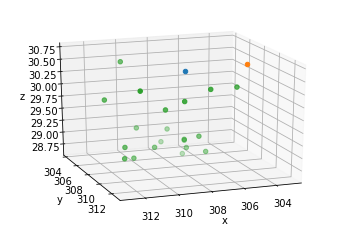

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lab1_center[0], lab1_center[1], lab1_center[2])
ax.scatter(lab2_center[0], lab2_center[1], lab2_center[2])
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

ax.view_init(20, 70)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

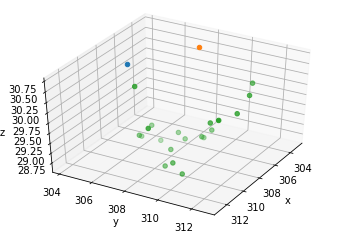

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lab1_center[0], lab1_center[1], lab1_center[2])
ax.scatter(lab2_center[0], lab2_center[1], lab2_center[2])
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

ax.view_init(40, 30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

### Library

Residuals between the observed 2D points and the projected 3D points for library 1 0.03656398212142175
Residuals between the observed 2D points and the projected 3D points for library 2 0.13383975630881217


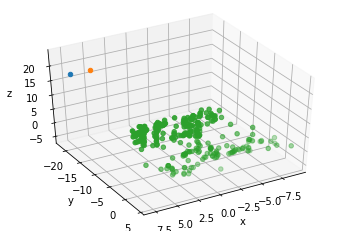

In [22]:
library_matches = np.loadtxt('library_matches.txt')
N = len(library_matches)

# 2d points on two images
attach = np.ones((N, 1))
x1 = np.hstack((library_matches[:, : 2], attach))
x2 = np.hstack((library_matches[:, 2 :], attach))

X_3d = np.zeros((N, 4))
for i in range(N):
    x_1 = np.zeros((3, 3))
    x_1[0, 1] = -1 * x1[i, 2]
    x_1[0, 2] = x1[i, 1]
    x_1[1, 0] = x1[i, 2]
    x_1[1, 2] = -1 * x1[i, 0]
    x_1[2, 0] = -1 * x1[i, 1]
    x_1[2, 1] = x1[i, 0]
    
    x_2 = np.zeros((3, 3))
    x_2[0, 1] = -1 * x2[i, 2]
    x_2[0, 2] = x2[i, 1]
    x_2[1, 0] = x2[i, 2]
    x_2[1, 2] = -1 * x2[i, 0]
    x_2[2, 0] = -1 * x2[i, 1]
    x_2[2, 1] = x2[i, 0]

    A_x1 = np.matmul(x_1, library1_camera_matrix)
    A_x2 = np.matmul(x_2, library2_camera_matrix)
    A = np.vstack((A_x1, A_x2))

    U, s, V = np.linalg.svd(A)
    sol = V[len(V)-1]
    X_3d[i] = sol / sol[-1]

#X_3d = X_3d[:, :-1]
#print(X_3d)

# Residual
residual_1 = 0
for i in range(N):
    # project to 2d
    x_1 = np.matmul(library1_camera_matrix, X_3d[i])
    x_1 = x_1 / x_1[-1]
    x_1 = x_1[: -1]
    residual_1 += np.sum(np.square(x_1 - library_matches[i, : 2]))
residual_1 = residual_1 / (2 * N)
print('Residuals between the observed 2D points and the projected 3D points for library 1', residual_1)
residual_2 = 0
for i in range(N):
    x_2 = np.matmul(library2_camera_matrix, X_3d[i])
    x_2 = x_2 / x_2[-1]
    x_2 = x_2[: -1]
    residual_2 += np.sum(np.square(x_2 - library_matches[i, 2 : ]))

residual_2 = residual_2 / (2 * N)
print('Residuals between the observed 2D points and the projected 3D points for library 2', residual_2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(library1_center[0], library1_center[1], library1_center[2])
ax.scatter(library2_center[0], library2_center[1], library2_center[2])
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

ax.view_init(40, 60)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

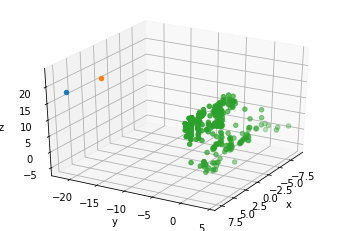

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(library1_center[0], library1_center[1], library1_center[2])
ax.scatter(library2_center[0], library2_center[1], library2_center[2])
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

ax.view_init(30, 30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

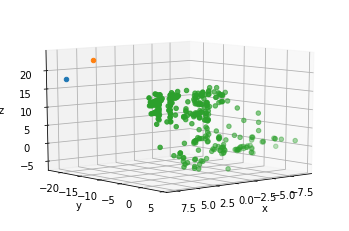

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(library1_center[0], library1_center[1], library1_center[2])
ax.scatter(library2_center[0], library2_center[1], library2_center[2])
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

ax.view_init(10, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()